# REBER Grammar with RNN

In this workbook, we are going to set-up multiple Recurrent Neural Network to test them using as test <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words.

## What is a Reber Word

A Reber word is a word following the Reber's grammar. The grammar is based on the following graph:

<img src="reber.gif"/>

The word must start with B, then it can be either T or P and so on until it reaches E. To prepare data for this, we are going to use a OneHotEncoder to have 7 inputs, n timesteps (depending on the length of the word) and k batches. To generate it, I use the algorith from <a href="http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php" target="_target">this site</a>

It also exists an Embedded version of the Reber Grammar which is :

<img src="embreber.gif"/>

For now, we gonna focus on the simple version and based on the result, we may try the embedded version.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

Using TensorFlow backend.


## Preparation of datas

For the OneHotEncoder, the chain 'BTSXPVE' will be used. We can now try only 1 example to check the output

In [30]:
x, y = reber.get_one_example(minLength=10)
print(reber.sequenceToWord(x))
print(x[0], y[0])

BPTVPXTTTVV
[ 1.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  1.  0.  0.]


In [32]:
def generate(x0):
    end = np.array([0.,  0.,  0.,  0.,  0.,  0.,  1.])
    y=x0[1:]
    y.append(end)
    return y

# print(generate(x))

So we have one example which is of course valid. We can see what is the related string (=> BTXXTVPXVV) or check the input and output for every timesteps

[ 1.  0.  0.  0.  0.  0.  0.] means B <br>
[ 0.  1.  0.  0.  1.  0.  0.] means either T or P

We never have the E as the algo stops when the output is E. The reason is that after E, we don't have any output so we do'nt have it in the input.

We can also generate few words to check the output.

In [33]:
min_length = 10
for i in range(10):
    inp, out = reber.get_one_example(min_length)
    print(reber.sequenceToWord(inp))

BTSXXVPXVV
BTSSSXXTTVPS
BTSSSSSXXTTTTTVPXTVV
BPTTTVPXVV
BPVPXTTTVV
BPTTVPXVPS
BTSSXXTVPS
BPVPXTTVPS
BTXXTVPXTTTVV
BPTTTTVPXTTVPXTTVV


So we have the first "problem" now, the length of the string is variable. So when we are going to generate our test/train datas, we will have to pad them to the same length (let's say 20)

In [34]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []

for i in range(2048):
    x, y = reber.get_one_example(min_length)
    X_train.append(x)
    y_train.append(generate(x))

for i in range(256):
    x, y = reber.get_one_example(min_length)
    X_test.append(x)
    y_test.append(generate(x))  
    
for i in range(1):
    x, y = reber.get_one_example(min_length)
    X_val.append(x)
    y_val.append(generate(x))
    y_possible = y

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_possible = np.array(y_possible)

maxlen = 20
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = sequence.pad_sequences(y_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
y_test = sequence.pad_sequences(y_test, maxlen=maxlen)
X_val = sequence.pad_sequences(X_val, maxlen=maxlen)
y_val = sequence.pad_sequences(y_val, maxlen=maxlen)
y_possible = sequence.pad_sequences(y_possible, maxlen=maxlen)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(y_possible.shape)

(2048, 20, 7)
(2048, 20, 7)
(256, 20, 7)
(256, 20, 7)
(1, 20, 7)
(1, 20, 7)


So now we have 800 strings for training, 50 for test and 1 just for visualisation later. We can now set-up our model.

## Test of RNNs

### LSTM

LSTM is the most used RNN currently. It's beacuse it's faster to train, use less memory/computation time. Nevertheless, we will try also simple RNN and GRU.

In [35]:
model = Sequential()

model.add(LSTM(units=7, input_shape=(maxlen, 7), return_sequences=True))
model.compile(loss='mse',
              optimizer='Nadam',
              metrics=['mean_squared_error'])

In [36]:
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 20, 7)
Outputs: (None, 20, 7)
Actual input: (2048, 20, 7)
Actual output: (2048, 20, 7)


In [37]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1500, batch_size=1024)
print(model.summary(), end=" ")

Train on 2048 samples, validate on 256 samples
Epoch 1/1500
2048/2048 [==============================] - 2s - loss: 0.1067 - mean_squared_error: 0.1067 - val_loss: 0.1043 - val_mean_squared_error: 0.1043
Epoch 2/1500
2048/2048 [==============================] - 0s - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 0.1029 - val_mean_squared_error: 0.1029
Epoch 3/1500
2048/2048 [==============================] - 0s - loss: 0.1035 - mean_squared_error: 0.1035 - val_loss: 0.1016 - val_mean_squared_error: 0.1016
Epoch 4/1500
2048/2048 [==============================] - 0s - loss: 0.1021 - mean_squared_error: 0.1021 - val_loss: 0.1003 - val_mean_squared_error: 0.1003
Epoch 5/1500
2048/2048 [==============================] - 0s - loss: 0.1009 - mean_squared_error: 0.1009 - val_loss: 0.0990 - val_mean_squared_error: 0.0990
Epoch 6/1500
2048/2048 [==============================] - 0s - loss: 0.0996 - mean_squared_error: 0.0996 - val_loss: 0.0978 - val_mean_squared_error: 0.0978
Epoch 7/150

2048/2048 [==============================] - 0s - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0699 - val_mean_squared_error: 0.0699
Epoch 53/1500
2048/2048 [==============================] - 0s - loss: 0.0704 - mean_squared_error: 0.0704 - val_loss: 0.0697 - val_mean_squared_error: 0.0697
Epoch 54/1500
2048/2048 [==============================] - 0s - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 0.0695 - val_mean_squared_error: 0.0695
Epoch 55/1500
2048/2048 [==============================] - 0s - loss: 0.0699 - mean_squared_error: 0.0699 - val_loss: 0.0693 - val_mean_squared_error: 0.0693
Epoch 56/1500
2048/2048 [==============================] - 0s - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0690 - val_mean_squared_error: 0.0690
Epoch 57/1500
2048/2048 [==============================] - 0s - loss: 0.0695 - mean_squared_error: 0.0695 - val_loss: 0.0688 - val_mean_squared_error: 0.0688
Epoch 58/1500
2048/2048 [==============================] - 0s - lo

2048/2048 [==============================] - 0s - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0601 - val_mean_squared_error: 0.0601
Epoch 104/1500
2048/2048 [==============================] - 0s - loss: 0.0606 - mean_squared_error: 0.0606 - val_loss: 0.0600 - val_mean_squared_error: 0.0600
Epoch 105/1500
2048/2048 [==============================] - 0s - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 0.0598 - val_mean_squared_error: 0.0598
Epoch 106/1500
2048/2048 [==============================] - 0s - loss: 0.0602 - mean_squared_error: 0.0602 - val_loss: 0.0596 - val_mean_squared_error: 0.0596
Epoch 107/1500
2048/2048 [==============================] - 0s - loss: 0.0600 - mean_squared_error: 0.0600 - val_loss: 0.0594 - val_mean_squared_error: 0.0594
Epoch 108/1500
2048/2048 [==============================] - 0s - loss: 0.0598 - mean_squared_error: 0.0598 - val_loss: 0.0592 - val_mean_squared_error: 0.0592
Epoch 109/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0525 - mean_squared_error: 0.0525 - val_loss: 0.0520 - val_mean_squared_error: 0.0520
Epoch 155/1500
2048/2048 [==============================] - 0s - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 0.0519 - val_mean_squared_error: 0.0519
Epoch 156/1500
2048/2048 [==============================] - 0s - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 157/1500
2048/2048 [==============================] - 0s - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 158/1500
2048/2048 [==============================] - 0s - loss: 0.0520 - mean_squared_error: 0.0520 - val_loss: 0.0515 - val_mean_squared_error: 0.0515
Epoch 159/1500
2048/2048 [==============================] - 0s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0514 - val_mean_squared_error: 0.0514
Epoch 160/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0470 - val_mean_squared_error: 0.0470
Epoch 206/1500
2048/2048 [==============================] - 0s - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 207/1500
2048/2048 [==============================] - 0s - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 208/1500
2048/2048 [==============================] - 0s - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 209/1500
2048/2048 [==============================] - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 210/1500
2048/2048 [==============================] - 0s - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 211/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 257/1500
2048/2048 [==============================] - 0s - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0436 - val_mean_squared_error: 0.0436
Epoch 258/1500
2048/2048 [==============================] - 0s - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 259/1500
2048/2048 [==============================] - 0s - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 260/1500
2048/2048 [==============================] - 0s - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 261/1500
2048/2048 [==============================] - 0s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 262/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0409 - val_mean_squared_error: 0.0409
Epoch 308/1500
2048/2048 [==============================] - 0s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 309/1500
2048/2048 [==============================] - 0s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 310/1500
2048/2048 [==============================] - 0s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 311/1500
2048/2048 [==============================] - 0s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 312/1500
2048/2048 [==============================] - 0s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 313/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 359/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 360/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 361/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 362/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 363/1500
2048/2048 [==============================] - 0s - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 364/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 410/1500
2048/2048 [==============================] - 0s - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 411/1500
2048/2048 [==============================] - 0s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 412/1500
2048/2048 [==============================] - 0s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 413/1500
2048/2048 [==============================] - 0s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 414/1500
2048/2048 [==============================] - 0s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 415/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 461/1500
2048/2048 [==============================] - 0s - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 462/1500
2048/2048 [==============================] - 0s - loss: 0.0357 - mean_squared_error: 0.0357 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 463/1500
2048/2048 [==============================] - 0s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 464/1500
2048/2048 [==============================] - 0s - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 465/1500
2048/2048 [==============================] - 0s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 466/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 512/1500
2048/2048 [==============================] - 0s - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 513/1500
2048/2048 [==============================] - 0s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 514/1500
2048/2048 [==============================] - 0s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 515/1500
2048/2048 [==============================] - 0s - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 516/1500
2048/2048 [==============================] - 0s - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 517/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 563/1500
2048/2048 [==============================] - 0s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 564/1500
2048/2048 [==============================] - 0s - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 565/1500
2048/2048 [==============================] - 0s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 566/1500
2048/2048 [==============================] - 0s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 567/1500
2048/2048 [==============================] - 0s - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 568/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 614/1500
2048/2048 [==============================] - 0s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 615/1500
2048/2048 [==============================] - 0s - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 616/1500
2048/2048 [==============================] - 0s - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 617/1500
2048/2048 [==============================] - 0s - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 618/1500
2048/2048 [==============================] - 0s - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 619/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 665/1500
2048/2048 [==============================] - 0s - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 666/1500
2048/2048 [==============================] - 0s - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 667/1500
2048/2048 [==============================] - 0s - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 668/1500
2048/2048 [==============================] - 0s - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 669/1500
2048/2048 [==============================] - 0s - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 670/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 716/1500
2048/2048 [==============================] - 0s - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 717/1500
2048/2048 [==============================] - 0s - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 718/1500
2048/2048 [==============================] - 0s - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 719/1500
2048/2048 [==============================] - 0s - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 720/1500
2048/2048 [==============================] - 0s - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 721/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 767/1500
2048/2048 [==============================] - 0s - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 768/1500
2048/2048 [==============================] - 0s - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 769/1500
2048/2048 [==============================] - 0s - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 770/1500
2048/2048 [==============================] - 0s - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 771/1500
2048/2048 [==============================] - 0s - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 772/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 818/1500
2048/2048 [==============================] - 0s - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 819/1500
2048/2048 [==============================] - 0s - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 820/1500
2048/2048 [==============================] - 0s - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 821/1500
2048/2048 [==============================] - 0s - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 822/1500
2048/2048 [==============================] - 0s - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 823/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 869/1500
2048/2048 [==============================] - 0s - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 870/1500
2048/2048 [==============================] - 0s - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 871/1500
2048/2048 [==============================] - 0s - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 872/1500
2048/2048 [==============================] - 0s - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 873/1500
2048/2048 [==============================] - 0s - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 874/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 920/1500
2048/2048 [==============================] - 0s - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 921/1500
2048/2048 [==============================] - 0s - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 922/1500
2048/2048 [==============================] - 0s - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 923/1500
2048/2048 [==============================] - 0s - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 924/1500
2048/2048 [==============================] - 0s - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 925/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 971/1500
2048/2048 [==============================] - 0s - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 972/1500
2048/2048 [==============================] - 0s - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 973/1500
2048/2048 [==============================] - 0s - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 974/1500
2048/2048 [==============================] - 0s - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 975/1500
2048/2048 [==============================] - 0s - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 976/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 1022/1500
2048/2048 [==============================] - 0s - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 1023/1500
2048/2048 [==============================] - 0s - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 1024/1500
2048/2048 [==============================] - 0s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 1025/1500
2048/2048 [==============================] - 0s - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 1026/1500
2048/2048 [==============================] - 0s - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 1027/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 1073/1500
2048/2048 [==============================] - 0s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 1074/1500
2048/2048 [==============================] - 0s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 1075/1500
2048/2048 [==============================] - 0s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 1076/1500
2048/2048 [==============================] - 0s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 1077/1500
2048/2048 [==============================] - 0s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 1078/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 1124/1500
2048/2048 [==============================] - 0s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 1125/1500
2048/2048 [==============================] - 0s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 1126/1500
2048/2048 [==============================] - 0s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 1127/1500
2048/2048 [==============================] - 0s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 1128/1500
2048/2048 [==============================] - 0s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 1129/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 1175/1500
2048/2048 [==============================] - 0s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 1176/1500
2048/2048 [==============================] - 0s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 1177/1500
2048/2048 [==============================] - 0s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 1178/1500
2048/2048 [==============================] - 0s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 1179/1500
2048/2048 [==============================] - 0s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 1180/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 1226/1500
2048/2048 [==============================] - 0s - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 1227/1500
2048/2048 [==============================] - 0s - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 1228/1500
2048/2048 [==============================] - 0s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 1229/1500
2048/2048 [==============================] - 0s - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 1230/1500
2048/2048 [==============================] - 0s - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 1231/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 1277/1500
2048/2048 [==============================] - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 1278/1500
2048/2048 [==============================] - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 1279/1500
2048/2048 [==============================] - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 1280/1500
2048/2048 [==============================] - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 1281/1500
2048/2048 [==============================] - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 1282/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 1328/1500
2048/2048 [==============================] - 0s - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 1329/1500
2048/2048 [==============================] - 0s - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 1330/1500
2048/2048 [==============================] - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 1331/1500
2048/2048 [==============================] - 0s - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 1332/1500
2048/2048 [==============================] - 0s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 1333/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 1379/1500
2048/2048 [==============================] - 0s - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 1380/1500
2048/2048 [==============================] - 0s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 1381/1500
2048/2048 [==============================] - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 1382/1500
2048/2048 [==============================] - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 1383/1500
2048/2048 [==============================] - 0s - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 1384/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 1430/1500
2048/2048 [==============================] - 0s - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 1431/1500
2048/2048 [==============================] - 0s - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 1432/1500
2048/2048 [==============================] - 0s - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 1433/1500
2048/2048 [==============================] - 0s - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 1434/1500
2048/2048 [==============================] - 0s - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 1435/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 1481/1500
2048/2048 [==============================] - 0s - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 1482/1500
2048/2048 [==============================] - 0s - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 1483/1500
2048/2048 [==============================] - 0s - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 1484/1500
2048/2048 [==============================] - 0s - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 1485/1500
2048/2048 [==============================] - 0s - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 1486/1500
2048/2048 [=============================

## Simple RNN

In [38]:
model2 = Sequential()
model2.add(SimpleRNN(units=7, input_shape=(maxlen, 7), return_sequences=True))
model2.compile(loss='mse',
              optimizer='Nadam',
              metrics=['mean_squared_error'])

In [39]:
print("Inputs: {}".format(model2.input_shape))
print("Outputs: {}".format(model2.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 20, 7)
Outputs: (None, 20, 7)
Actual input: (2048, 20, 7)
Actual output: (2048, 20, 7)


In [40]:
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1500, batch_size=1024)
print(model2.summary(), end=" ")

Train on 2048 samples, validate on 256 samples
Epoch 1/1500
2048/2048 [==============================] - 0s - loss: 0.2578 - mean_squared_error: 0.2578 - val_loss: 0.2484 - val_mean_squared_error: 0.2484
Epoch 2/1500
2048/2048 [==============================] - 0s - loss: 0.2467 - mean_squared_error: 0.2467 - val_loss: 0.2411 - val_mean_squared_error: 0.2411
Epoch 3/1500
2048/2048 [==============================] - 0s - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2347 - val_mean_squared_error: 0.2347
Epoch 4/1500
2048/2048 [==============================] - 0s - loss: 0.2333 - mean_squared_error: 0.2333 - val_loss: 0.2286 - val_mean_squared_error: 0.2286
Epoch 5/1500
2048/2048 [==============================] - 0s - loss: 0.2273 - mean_squared_error: 0.2273 - val_loss: 0.2229 - val_mean_squared_error: 0.2229
Epoch 6/1500
2048/2048 [==============================] - 0s - loss: 0.2217 - mean_squared_error: 0.2217 - val_loss: 0.2175 - val_mean_squared_error: 0.2175
Epoch 7/150

2048/2048 [==============================] - 0s - loss: 0.1060 - mean_squared_error: 0.1060 - val_loss: 0.1048 - val_mean_squared_error: 0.1048
Epoch 53/1500
2048/2048 [==============================] - 0s - loss: 0.1048 - mean_squared_error: 0.1048 - val_loss: 0.1036 - val_mean_squared_error: 0.1036
Epoch 54/1500
2048/2048 [==============================] - 0s - loss: 0.1036 - mean_squared_error: 0.1036 - val_loss: 0.1024 - val_mean_squared_error: 0.1024
Epoch 55/1500
2048/2048 [==============================] - 0s - loss: 0.1024 - mean_squared_error: 0.1024 - val_loss: 0.1013 - val_mean_squared_error: 0.1013
Epoch 56/1500
2048/2048 [==============================] - 0s - loss: 0.1013 - mean_squared_error: 0.1013 - val_loss: 0.1002 - val_mean_squared_error: 0.1002
Epoch 57/1500
2048/2048 [==============================] - 0s - loss: 0.1002 - mean_squared_error: 0.1002 - val_loss: 0.0991 - val_mean_squared_error: 0.0991
Epoch 58/1500
2048/2048 [==============================] - 0s - lo

2048/2048 [==============================] - 0s - loss: 0.0735 - mean_squared_error: 0.0735 - val_loss: 0.0731 - val_mean_squared_error: 0.0731
Epoch 104/1500
2048/2048 [==============================] - 0s - loss: 0.0732 - mean_squared_error: 0.0732 - val_loss: 0.0728 - val_mean_squared_error: 0.0728
Epoch 105/1500
2048/2048 [==============================] - 0s - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0725 - val_mean_squared_error: 0.0725
Epoch 106/1500
2048/2048 [==============================] - 0s - loss: 0.0726 - mean_squared_error: 0.0726 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 107/1500
2048/2048 [==============================] - 0s - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0720 - val_mean_squared_error: 0.0720
Epoch 108/1500
2048/2048 [==============================] - 0s - loss: 0.0720 - mean_squared_error: 0.0720 - val_loss: 0.0717 - val_mean_squared_error: 0.0717
Epoch 109/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0631 - val_mean_squared_error: 0.0631
Epoch 155/1500
2048/2048 [==============================] - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
Epoch 156/1500
2048/2048 [==============================] - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0629 - val_mean_squared_error: 0.0629
Epoch 157/1500
2048/2048 [==============================] - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0628 - val_mean_squared_error: 0.0628
Epoch 158/1500
2048/2048 [==============================] - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0626 - val_mean_squared_error: 0.0626
Epoch 159/1500
2048/2048 [==============================] - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625
Epoch 160/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0588 - mean_squared_error: 0.0588 - val_loss: 0.0585 - val_mean_squared_error: 0.0585
Epoch 206/1500
2048/2048 [==============================] - 0s - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 0.0585 - val_mean_squared_error: 0.0585
Epoch 207/1500
2048/2048 [==============================] - 0s - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 0.0584 - val_mean_squared_error: 0.0584
Epoch 208/1500
2048/2048 [==============================] - 0s - loss: 0.0586 - mean_squared_error: 0.0586 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 209/1500
2048/2048 [==============================] - 0s - loss: 0.0585 - mean_squared_error: 0.0585 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 210/1500
2048/2048 [==============================] - 0s - loss: 0.0585 - mean_squared_error: 0.0585 - val_loss: 0.0582 - val_mean_squared_error: 0.0582
Epoch 211/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0561 - mean_squared_error: 0.0561 - val_loss: 0.0558 - val_mean_squared_error: 0.0558
Epoch 257/1500
2048/2048 [==============================] - 0s - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0558 - val_mean_squared_error: 0.0558
Epoch 258/1500
2048/2048 [==============================] - 0s - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0558 - val_mean_squared_error: 0.0558
Epoch 259/1500
2048/2048 [==============================] - 0s - loss: 0.0559 - mean_squared_error: 0.0559 - val_loss: 0.0557 - val_mean_squared_error: 0.0557
Epoch 260/1500
2048/2048 [==============================] - 0s - loss: 0.0559 - mean_squared_error: 0.0559 - val_loss: 0.0557 - val_mean_squared_error: 0.0557
Epoch 261/1500
2048/2048 [==============================] - 0s - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0556 - val_mean_squared_error: 0.0556
Epoch 262/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0542 - mean_squared_error: 0.0542 - val_loss: 0.0540 - val_mean_squared_error: 0.0540
Epoch 308/1500
2048/2048 [==============================] - 0s - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0540 - val_mean_squared_error: 0.0540
Epoch 309/1500
2048/2048 [==============================] - 0s - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0540 - val_mean_squared_error: 0.0540
Epoch 310/1500
2048/2048 [==============================] - 0s - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0539 - val_mean_squared_error: 0.0539
Epoch 311/1500
2048/2048 [==============================] - 0s - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0539 - val_mean_squared_error: 0.0539
Epoch 312/1500
2048/2048 [==============================] - 0s - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0539 - val_mean_squared_error: 0.0539
Epoch 313/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0528 - mean_squared_error: 0.0528 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 359/1500
2048/2048 [==============================] - 0s - loss: 0.0528 - mean_squared_error: 0.0528 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 360/1500
2048/2048 [==============================] - 0s - loss: 0.0528 - mean_squared_error: 0.0528 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 361/1500
2048/2048 [==============================] - 0s - loss: 0.0528 - mean_squared_error: 0.0528 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 362/1500
2048/2048 [==============================] - 0s - loss: 0.0527 - mean_squared_error: 0.0527 - val_loss: 0.0526 - val_mean_squared_error: 0.0526
Epoch 363/1500
2048/2048 [==============================] - 0s - loss: 0.0527 - mean_squared_error: 0.0527 - val_loss: 0.0526 - val_mean_squared_error: 0.0526
Epoch 364/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 410/1500
2048/2048 [==============================] - 0s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 411/1500
2048/2048 [==============================] - 0s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 412/1500
2048/2048 [==============================] - 0s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 413/1500
2048/2048 [==============================] - 0s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 414/1500
2048/2048 [==============================] - 0s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 415/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 461/1500
2048/2048 [==============================] - 0s - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 462/1500
2048/2048 [==============================] - 0s - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 463/1500
2048/2048 [==============================] - 0s - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 464/1500
2048/2048 [==============================] - 0s - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 465/1500
2048/2048 [==============================] - 0s - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoch 466/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 512/1500
2048/2048 [==============================] - 0s - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 513/1500
2048/2048 [==============================] - 0s - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 514/1500
2048/2048 [==============================] - 0s - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 515/1500
2048/2048 [==============================] - 0s - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 516/1500
2048/2048 [==============================] - 0s - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 517/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 563/1500
2048/2048 [==============================] - 0s - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 564/1500
2048/2048 [==============================] - 0s - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 565/1500
2048/2048 [==============================] - 0s - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 566/1500
2048/2048 [==============================] - 0s - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 567/1500
2048/2048 [==============================] - 0s - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 568/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0490 - mean_squared_error: 0.0490 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 614/1500
2048/2048 [==============================] - 0s - loss: 0.0490 - mean_squared_error: 0.0490 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 615/1500
2048/2048 [==============================] - 0s - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 616/1500
2048/2048 [==============================] - 0s - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 617/1500
2048/2048 [==============================] - 0s - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 618/1500
2048/2048 [==============================] - 0s - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 619/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 665/1500
2048/2048 [==============================] - 0s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 666/1500
2048/2048 [==============================] - 0s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 667/1500
2048/2048 [==============================] - 0s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 668/1500
2048/2048 [==============================] - 0s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 669/1500
2048/2048 [==============================] - 0s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 670/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 716/1500
2048/2048 [==============================] - 0s - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 717/1500
2048/2048 [==============================] - 0s - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 718/1500
2048/2048 [==============================] - 0s - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 719/1500
2048/2048 [==============================] - 0s - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 720/1500
2048/2048 [==============================] - 0s - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 721/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 767/1500
2048/2048 [==============================] - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 768/1500
2048/2048 [==============================] - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 769/1500
2048/2048 [==============================] - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 770/1500
2048/2048 [==============================] - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 771/1500
2048/2048 [==============================] - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 772/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 818/1500
2048/2048 [==============================] - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 819/1500
2048/2048 [==============================] - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 820/1500
2048/2048 [==============================] - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 821/1500
2048/2048 [==============================] - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 822/1500
2048/2048 [==============================] - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 823/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 868/1500
2048/2048 [==============================] - 0s - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 869/1500
2048/2048 [==============================] - 0s - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 870/1500
2048/2048 [==============================] - 0s - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 871/1500
2048/2048 [==============================] - 0s - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 872/1500
2048/2048 [==============================] - 0s - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 873/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 919/1500
2048/2048 [==============================] - 0s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 920/1500
2048/2048 [==============================] - 0s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 921/1500
2048/2048 [==============================] - 0s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 922/1500
2048/2048 [==============================] - 0s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 923/1500
2048/2048 [==============================] - 0s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 924/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 970/1500
2048/2048 [==============================] - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 971/1500
2048/2048 [==============================] - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 972/1500
2048/2048 [==============================] - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 973/1500
2048/2048 [==============================] - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 974/1500
2048/2048 [==============================] - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 975/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 1020/1500
2048/2048 [==============================] - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 1021/1500
2048/2048 [==============================] - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 1022/1500
2048/2048 [==============================] - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 1023/1500
2048/2048 [==============================] - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 1024/1500
2048/2048 [==============================] - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 1025/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1070/1500
2048/2048 [==============================] - ETA: 0s - loss: 0.0462 - mean_squared_error: 0.04 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1071/1500
2048/2048 [==============================] - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1072/1500
2048/2048 [==============================] - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1073/1500
2048/2048 [==============================] - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1074/1500
2048/2048 [==============================] - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoc

2048/2048 [==============================] - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1120/1500
2048/2048 [==============================] - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1121/1500
2048/2048 [==============================] - ETA: 0s - loss: 0.0460 - mean_squared_error: 0.04 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1122/1500
2048/2048 [==============================] - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1123/1500
2048/2048 [==============================] - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1124/1500
2048/2048 [==============================] - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoc

2048/2048 [==============================] - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 1170/1500
2048/2048 [==============================] - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 1171/1500
2048/2048 [==============================] - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 1172/1500
2048/2048 [==============================] - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 1173/1500
2048/2048 [==============================] - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 1174/1500
2048/2048 [==============================] - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 1175/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1221/1500
2048/2048 [==============================] - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1222/1500
2048/2048 [==============================] - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1223/1500
2048/2048 [==============================] - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1224/1500
2048/2048 [==============================] - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1225/1500
2048/2048 [==============================] - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1226/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1272/1500
2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1273/1500
2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1274/1500
2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1275/1500
2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1276/1500
2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 1277/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1322/1500
2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1323/1500
2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 1324/1500
2048/2048 [==============================] - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 1325/1500
2048/2048 [==============================] - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 1326/1500
2048/2048 [==============================] - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 1327/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1373/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1374/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1375/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1376/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1377/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1378/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1424/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1425/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 1426/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 1427/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 1428/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 1429/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 1474/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1475/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1476/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1477/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1478/1500
2048/2048 [==============================] - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 1479/1500
2048/2048 [=============================

## GRU

In [41]:
model3 = Sequential()
model3.add(GRU(units=7, input_shape=(maxlen, 7), return_sequences=True))
model3.compile(loss='mse',
              optimizer='Nadam',
              metrics=['mean_squared_error'])

In [42]:
print("Inputs: {}".format(model3.input_shape))
print("Outputs: {}".format(model3.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 20, 7)
Outputs: (None, 20, 7)
Actual input: (2048, 20, 7)
Actual output: (2048, 20, 7)


In [43]:
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1500, batch_size=1024)
print(model3.summary(), end=" ")

Train on 2048 samples, validate on 256 samples
Epoch 1/1500
2048/2048 [==============================] - 0s - loss: 0.0981 - mean_squared_error: 0.0981 - val_loss: 0.0965 - val_mean_squared_error: 0.0965
Epoch 2/1500
2048/2048 [==============================] - 0s - loss: 0.0966 - mean_squared_error: 0.0966 - val_loss: 0.0954 - val_mean_squared_error: 0.0954
Epoch 3/1500
2048/2048 [==============================] - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0943 - val_mean_squared_error: 0.0943
Epoch 4/1500
2048/2048 [==============================] - 0s - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0933 - val_mean_squared_error: 0.0933
Epoch 5/1500
2048/2048 [==============================] - 0s - loss: 0.0934 - mean_squared_error: 0.0934 - val_loss: 0.0923 - val_mean_squared_error: 0.0923
Epoch 6/1500
2048/2048 [==============================] - 0s - loss: 0.0924 - mean_squared_error: 0.0924 - val_loss: 0.0913 - val_mean_squared_error: 0.0913
Epoch 7/150

2048/2048 [==============================] - 0s - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0690 - val_mean_squared_error: 0.0690
Epoch 53/1500
2048/2048 [==============================] - 0s - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 0.0687 - val_mean_squared_error: 0.0687
Epoch 54/1500
2048/2048 [==============================] - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 55/1500
2048/2048 [==============================] - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0682 - val_mean_squared_error: 0.0682
Epoch 56/1500
2048/2048 [==============================] - 0s - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 57/1500
2048/2048 [==============================] - 0s - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0677 - val_mean_squared_error: 0.0677
Epoch 58/1500
2048/2048 [==============================] - 0s - lo

2048/2048 [==============================] - 0s - loss: 0.0578 - mean_squared_error: 0.0578 - val_loss: 0.0574 - val_mean_squared_error: 0.0574
Epoch 104/1500
2048/2048 [==============================] - 0s - loss: 0.0576 - mean_squared_error: 0.0576 - val_loss: 0.0573 - val_mean_squared_error: 0.0573
Epoch 105/1500
2048/2048 [==============================] - 0s - loss: 0.0574 - mean_squared_error: 0.0574 - val_loss: 0.0571 - val_mean_squared_error: 0.0571
Epoch 106/1500
2048/2048 [==============================] - 0s - loss: 0.0572 - mean_squared_error: 0.0572 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 107/1500
2048/2048 [==============================] - 0s - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.0567 - val_mean_squared_error: 0.0567
Epoch 108/1500
2048/2048 [==============================] - 0s - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 109/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 155/1500
2048/2048 [==============================] - 0s - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 156/1500
2048/2048 [==============================] - 0s - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 157/1500
2048/2048 [==============================] - 0s - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0493 - val_mean_squared_error: 0.0493
Epoch 158/1500
2048/2048 [==============================] - 0s - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 159/1500
2048/2048 [==============================] - 0s - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0491 - val_mean_squared_error: 0.0491
Epoch 160/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 206/1500
2048/2048 [==============================] - 0s - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 207/1500
2048/2048 [==============================] - 0s - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 208/1500
2048/2048 [==============================] - 0s - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 209/1500
2048/2048 [==============================] - 0s - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 210/1500
2048/2048 [==============================] - 0s - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
Epoch 211/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 257/1500
2048/2048 [==============================] - 0s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 258/1500
2048/2048 [==============================] - 0s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 259/1500
2048/2048 [==============================] - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 260/1500
2048/2048 [==============================] - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 261/1500
2048/2048 [==============================] - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 262/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 308/1500
2048/2048 [==============================] - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 309/1500
2048/2048 [==============================] - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 310/1500
2048/2048 [==============================] - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 311/1500
2048/2048 [==============================] - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 312/1500
2048/2048 [==============================] - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 313/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 359/1500
2048/2048 [==============================] - 0s - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 360/1500
2048/2048 [==============================] - 0s - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 361/1500
2048/2048 [==============================] - 0s - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Epoch 362/1500
2048/2048 [==============================] - 0s - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Epoch 363/1500
2048/2048 [==============================] - 0s - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Epoch 364/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0385 - mean_squared_error: 0.0385 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 410/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 411/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 412/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 413/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 414/1500
2048/2048 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 415/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 461/1500
2048/2048 [==============================] - 0s - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 462/1500
2048/2048 [==============================] - 0s - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 463/1500
2048/2048 [==============================] - 0s - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 464/1500
2048/2048 [==============================] - 0s - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 465/1500
2048/2048 [==============================] - 0s - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 466/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 512/1500
2048/2048 [==============================] - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 513/1500
2048/2048 [==============================] - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 514/1500
2048/2048 [==============================] - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 515/1500
2048/2048 [==============================] - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 516/1500
2048/2048 [==============================] - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 517/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 563/1500
2048/2048 [==============================] - 0s - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 564/1500
2048/2048 [==============================] - 0s - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 565/1500
2048/2048 [==============================] - 0s - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 566/1500
2048/2048 [==============================] - 0s - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 567/1500
2048/2048 [==============================] - 0s - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 568/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 614/1500
2048/2048 [==============================] - 0s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 615/1500
2048/2048 [==============================] - 0s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 616/1500
2048/2048 [==============================] - 0s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 617/1500
2048/2048 [==============================] - 0s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 618/1500
2048/2048 [==============================] - 0s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 619/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 665/1500
2048/2048 [==============================] - 0s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 666/1500
2048/2048 [==============================] - 0s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 667/1500
2048/2048 [==============================] - 0s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 668/1500
2048/2048 [==============================] - 0s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 669/1500
2048/2048 [==============================] - 0s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 670/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 716/1500
2048/2048 [==============================] - 0s - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 717/1500
2048/2048 [==============================] - 0s - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 718/1500
2048/2048 [==============================] - 0s - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 719/1500
2048/2048 [==============================] - 0s - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 720/1500
2048/2048 [==============================] - 0s - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 721/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 767/1500
2048/2048 [==============================] - 0s - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 768/1500
2048/2048 [==============================] - 0s - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 769/1500
2048/2048 [==============================] - 0s - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 770/1500
2048/2048 [==============================] - 0s - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 771/1500
2048/2048 [==============================] - 0s - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 772/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 818/1500
2048/2048 [==============================] - 0s - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 819/1500
2048/2048 [==============================] - 0s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 820/1500
2048/2048 [==============================] - 0s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 821/1500
2048/2048 [==============================] - 0s - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 822/1500
2048/2048 [==============================] - 0s - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 823/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 869/1500
2048/2048 [==============================] - 0s - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 870/1500
2048/2048 [==============================] - 0s - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 871/1500
2048/2048 [==============================] - 0s - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 872/1500
2048/2048 [==============================] - 0s - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 873/1500
2048/2048 [==============================] - 0s - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 874/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 920/1500
2048/2048 [==============================] - 0s - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 921/1500
2048/2048 [==============================] - 0s - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 922/1500
2048/2048 [==============================] - 0s - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 923/1500
2048/2048 [==============================] - 0s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 924/1500
2048/2048 [==============================] - 0s - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 925/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 971/1500
2048/2048 [==============================] - 0s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 972/1500
2048/2048 [==============================] - 0s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 973/1500
2048/2048 [==============================] - 0s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 974/1500
2048/2048 [==============================] - 0s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 975/1500
2048/2048 [==============================] - 0s - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 976/1500
2048/2048 [==============================] - 0

2048/2048 [==============================] - 0s - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 1022/1500
2048/2048 [==============================] - 0s - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 1023/1500
2048/2048 [==============================] - 0s - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 1024/1500
2048/2048 [==============================] - 0s - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 1025/1500
2048/2048 [==============================] - 0s - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 1026/1500
2048/2048 [==============================] - 0s - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 1027/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 1072/1500
2048/2048 [==============================] - 0s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 1073/1500
2048/2048 [==============================] - 0s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 1074/1500
2048/2048 [==============================] - 0s - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 1075/1500
2048/2048 [==============================] - 0s - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 1076/1500
2048/2048 [==============================] - 0s - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 1077/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1123/1500
2048/2048 [==============================] - 0s - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1124/1500
2048/2048 [==============================] - 0s - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 1125/1500
2048/2048 [==============================] - 0s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 1126/1500
2048/2048 [==============================] - 0s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 1127/1500
2048/2048 [==============================] - 0s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 1128/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1173/1500
2048/2048 [==============================] - 0s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 1174/1500
2048/2048 [==============================] - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 1175/1500
2048/2048 [==============================] - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 1176/1500
2048/2048 [==============================] - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 1177/1500
2048/2048 [==============================] - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 1178/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 1224/1500
2048/2048 [==============================] - 0s - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 1225/1500
2048/2048 [==============================] - 0s - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 1226/1500
2048/2048 [==============================] - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1227/1500
2048/2048 [==============================] - 0s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1228/1500
2048/2048 [==============================] - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 1229/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 1274/1500
2048/2048 [==============================] - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 1275/1500
2048/2048 [==============================] - 0s - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 1276/1500
2048/2048 [==============================] - 0s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 1277/1500
2048/2048 [==============================] - 0s - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 1278/1500
2048/2048 [==============================] - 0s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 1279/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 1325/1500
2048/2048 [==============================] - 0s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 1326/1500
2048/2048 [==============================] - 0s - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 1327/1500
2048/2048 [==============================] - 0s - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 1328/1500
2048/2048 [==============================] - 0s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 1329/1500
2048/2048 [==============================] - 0s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 1330/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 1376/1500
2048/2048 [==============================] - 0s - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 1377/1500
2048/2048 [==============================] - 0s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 1378/1500
2048/2048 [==============================] - 0s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 1379/1500
2048/2048 [==============================] - 0s - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 1380/1500
2048/2048 [==============================] - 0s - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 1381/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 1427/1500
2048/2048 [==============================] - 0s - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 1428/1500
2048/2048 [==============================] - 0s - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 1429/1500
2048/2048 [==============================] - 0s - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 1430/1500
2048/2048 [==============================] - 0s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 1431/1500
2048/2048 [==============================] - 0s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 1432/1500
2048/2048 [=============================

2048/2048 [==============================] - 0s - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 1478/1500
2048/2048 [==============================] - 0s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 1479/1500
2048/2048 [==============================] - 0s - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 1480/1500
2048/2048 [==============================] - 0s - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 1481/1500
2048/2048 [==============================] - 0s - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 1482/1500
2048/2048 [==============================] - 0s - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 1483/1500
2048/2048 [=============================

## Evaluation

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


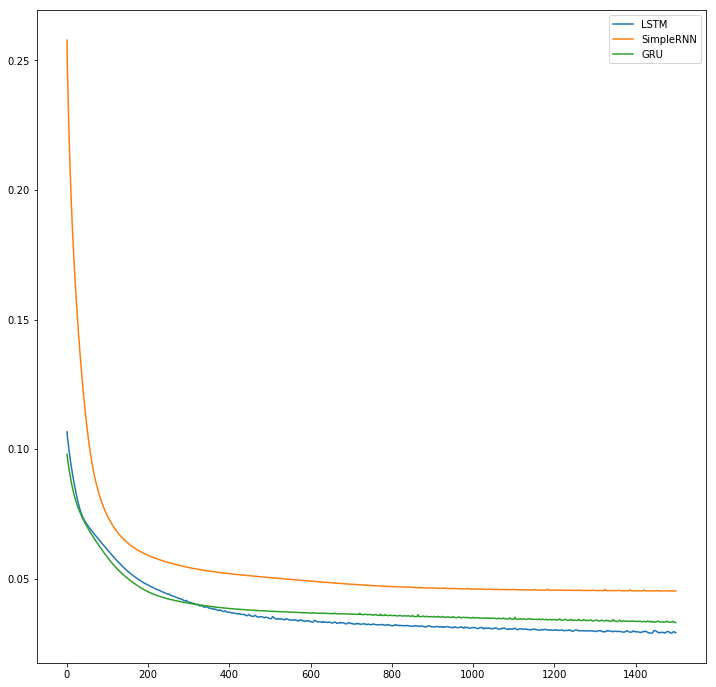

In [44]:
print(history.history.keys())
plt.figure(figsize=(12, 12))
plt.plot(history.history['mean_squared_error'], label="LSTM")
plt.plot(history2.history['mean_squared_error'], label="SimpleRNN")
plt.plot(history3.history['mean_squared_error'], label="GRU")
plt.legend()
plt.show()

We can see that GRU and LSTM perform better than a Simple RNN. Nevertheless, GRU is also performing better than the popular LSTM with the same settings

In [45]:
y_pred = model.predict(X_val)
print(y_pred, "\n")
y_pred = model3.predict(X_val)
print(y_pred)

[[[-0.005  0.001  0.009  0.001 -0.004 -0.005 -0.001]
  [-0.009  0.002  0.01   0.007 -0.005 -0.009 -0.003]
  [-0.013  0.005  0.006  0.014 -0.004 -0.012 -0.005]
  [-0.018  0.012 -0.001  0.018 -0.003 -0.013 -0.006]
  [-0.023  0.022 -0.008  0.021 -0.001 -0.014 -0.007]
  [-0.03   0.033 -0.016  0.023  0.002 -0.013 -0.008]
  [-0.038  0.045 -0.023  0.024  0.005 -0.01  -0.007]
  [-0.047  0.057 -0.029  0.024  0.008 -0.006 -0.006]
  [-0.007  0.557  0.044 -0.072  0.437 -0.009  0.02 ]
  [ 0.015  0.682 -0.012  0.084  0.013  0.07  -0.   ]
  [-0.054  0.066  0.007  0.     0.957 -0.061 -0.026]
  [-0.005  0.054 -0.069  0.918  0.     0.017  0.011]
  [-0.008  0.715 -0.002  0.026  0.     0.229 -0.024]
  [-0.067  0.033  0.     0.     0.956  0.077 -0.011]
  [-0.006  0.007  0.018  0.872  0.     0.079  0.044]
  [-0.003  0.567  0.008 -0.012  0.     0.474 -0.011]
  [ 0.006  0.456  0.012 -0.     0.     0.604 -0.   ]
  [-0.002 -0.054  0.     0.     0.55   0.497  0.164]
  [ 0.052 -0.033  0.791 -0.119 -0.     0.274  

In [46]:
#y_pred = np.absolute(y_pred)
y_pred = np.where(y_pred < 0.1, 0, y_pred)
# row_sums = y_pred[0].sum(axis=1)

# with np.errstate(divide='ignore', invalid='ignore'):
#     y_pred = np.true_divide(y_pred, row_sums[:, np.newaxis])
#     y_pred[y_pred == np.inf] = 0
#     y_pred = np.nan_to_num(y_pred)
# print(y_pred)

In [47]:
for pred, real in zip(y_pred[0], y_possible[0]):
    print(pred, "\t", real)

[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.     0.622  0.     0.     0.401  0.     0.   ] 	 [0 0 0 0 1 0 0]
[ 0.     0.646  0.     0.     0.     0.281  0.   ] 	 [0 0 0 0 0 1 0]
[ 0.115  0.     0.     0.     0.884  0.     0.   ] 	 [0 0 0 0 1 0 0]
[ 0.     0.     0.122  0.855  0.     0.     0.   ] 	 [0 0 0 1 0 0 0]
[ 0.     0.662  0.     0.     0.     0.321  0.   ] 	 [0 0 0 0 0 1 0]
[ 0.     0.     0.     0.     0.871  0.     0.   ] 	 [0 0 0 0 1 0 0]
[ 0.     0.     0.113  0.833  0.     0.     0.   ] 	 [0 0 0 1 0 0 0]
[ 0.     0.567  0.     0.     0.     0.474  0.   ] 	 [0 1 0 0 0 0 0]
[ 0.     0.527  0.     0.     0.     0.565  0.   ] 	 [0 0 0 0 0 

## Use it as generator

In [58]:
# print(X_val[0][8:])
# print(model.predict(X_val)[0][8:])

test = np.array([[[1,0,0,0,0,0,0], [0,1,0,0,0,0,0]]])
test = sequence.pad_sequences(test, maxlen=maxlen)
print(model.predict(X_val)[0])
print(test)

[[-0.005  0.001  0.009  0.001 -0.004 -0.005 -0.001]
 [-0.009  0.002  0.01   0.007 -0.005 -0.009 -0.003]
 [-0.013  0.005  0.006  0.014 -0.004 -0.012 -0.005]
 [-0.018  0.012 -0.001  0.018 -0.003 -0.013 -0.006]
 [-0.023  0.022 -0.008  0.021 -0.001 -0.014 -0.007]
 [-0.03   0.033 -0.016  0.023  0.002 -0.013 -0.008]
 [-0.038  0.045 -0.023  0.024  0.005 -0.01  -0.007]
 [-0.047  0.057 -0.029  0.024  0.008 -0.006 -0.006]
 [-0.007  0.557  0.044 -0.072  0.437 -0.009  0.02 ]
 [ 0.015  0.682 -0.012  0.084  0.013  0.07  -0.   ]
 [-0.054  0.066  0.007  0.     0.957 -0.061 -0.026]
 [-0.005  0.054 -0.069  0.918  0.     0.017  0.011]
 [-0.008  0.715 -0.002  0.026  0.     0.229 -0.024]
 [-0.067  0.033  0.     0.     0.956  0.077 -0.011]
 [-0.006  0.007  0.018  0.872  0.     0.079  0.044]
 [-0.003  0.567  0.008 -0.012  0.     0.474 -0.011]
 [ 0.006  0.456  0.012 -0.     0.     0.604 -0.   ]
 [-0.002 -0.054  0.     0.     0.55   0.497  0.164]
 [ 0.052 -0.033  0.791 -0.119 -0.     0.274  0.159]
 [ 0.059 -0.